# Value Iteration. Policy Iteration.

In [1]:
!pip install numpy==1.23.5

In [2]:
import gym
import os
import numpy as np
import itertools
from collections import defaultdict
from gym.envs import toy_text
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import clear_output, display
%matplotlib inline
gym.__version__

'0.25.2'

## Value Iteration

На лекции мы рассмотрели, как мы можем выучить оптимальную политику, используя алгоритм Value Iteration, если нам известна динамика среды, а также если пространства состояний и действий не большие и дискретные.

Попробуем выучить оптимальную политику в среде <a href=https://gymnasium.farama.org/environments/toy_text/frozen_lake/>FrozenLake-v1</a>. Это простая среда с маленькими пространствами состояний и действий, а также с известной динамикой.

Создадим среду и выведем её описание.

In [3]:
env = gym.make('FrozenLake-v1', render_mode='rgb_array')
env.reset()

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Observation space: Discrete(16)
Action space: Discrete(4)


In [4]:
print(env.env.__doc__)

A wrapper that will produce an error if :meth:`step` is called before an initial :meth:`reset`.

    Example:
        >>> from gym.envs.classic_control import CartPoleEnv
        >>> env = CartPoleEnv()
        >>> env = OrderEnforcing(env)
        >>> env.step(0)
        ResetNeeded: Cannot call env.step() before calling env.reset()
        >>> env.render()
        ResetNeeded: Cannot call env.render() before calling env.reset()
        >>> env.reset()
        >>> env.render()
        >>> env.step(0)
    


(256, 256, 3)


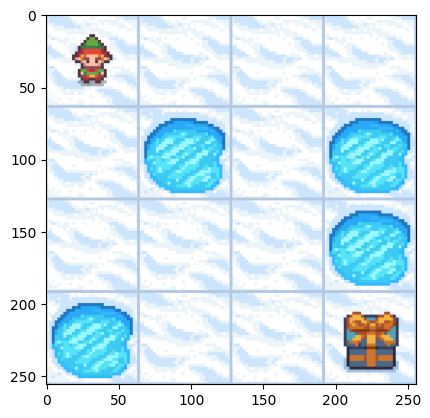

In [5]:
env_screen = np.squeeze(np.array(env.render()))
print(env_screen.shape)
plt.imshow(env_screen)
plt.show()

Как видно среда представляет собой поле 4 на 4, по которому нужно добраться от начала (клетка *S*) до цели (клетка *G*). При этом среда является недетерменированный - с определенной вероятностью при совершения действия агент подскользнется и попадет не в ту клетку, в которую направлялся. Клетка *H* обозначает прорубь. Игра закначивается, когда агент попадает в клетку *G* или в клету *H*. Если агент проваливается в прорубь, то он получает награду *0*, если достигает клетки цели *1*.

Посмотрим на отображение игры и сколько в среднем очков награды за 100 эпизодов получит наш агент, если будет выполнять случайные действия.

In [6]:
env.reset(seed=42);

In [7]:
env = gym.make('FrozenLake-v1', render_mode='rgb_array')

TIME_LIMIT = 5
total_reward = []

for episode in range(TIME_LIMIT):
    clear_output(wait=True)

    episode_reward = 0
    observation = env.reset()

    for t in range(TIME_LIMIT):
        action = env.action_space.sample()
        observation, reward, done, _ = env.step(action)

        frames = env.render()
        frame = frames[0]
        plt.imshow(frame)
        display(plt.gcf())
        plt.pause(0.1)
        clear_output(wait=True)

        episode_reward += reward
        if done:
            print(f"Episode {episode+1} finished after {t+1} timesteps")
            break

    total_reward.append(episode_reward)

env.close()

Episode 5 finished after 2 timesteps


In [8]:
TIME_LIMIT = 100

total_reward = []
for episode in range(TIME_LIMIT):
    episode_reward = 0
    observation = env.reset()
    for t in range(TIME_LIMIT):
        # env.render()
        action = env.action_space.sample()
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        if done:
            print("Episode {} finished after {} timesteps".format(episode+1, t+1))
            break
    total_reward.append(episode_reward)

Episode 1 finished after 9 timesteps
Episode 2 finished after 5 timesteps
Episode 3 finished after 4 timesteps
Episode 4 finished after 5 timesteps
Episode 5 finished after 4 timesteps
Episode 6 finished after 5 timesteps
Episode 7 finished after 8 timesteps
Episode 8 finished after 14 timesteps
Episode 9 finished after 3 timesteps
Episode 10 finished after 10 timesteps
Episode 11 finished after 6 timesteps
Episode 12 finished after 5 timesteps
Episode 13 finished after 8 timesteps
Episode 14 finished after 7 timesteps
Episode 15 finished after 7 timesteps
Episode 16 finished after 6 timesteps
Episode 17 finished after 4 timesteps
Episode 18 finished after 8 timesteps
Episode 19 finished after 6 timesteps
Episode 20 finished after 6 timesteps
Episode 21 finished after 7 timesteps
Episode 22 finished after 3 timesteps
Episode 23 finished after 7 timesteps
Episode 24 finished after 6 timesteps
Episode 25 finished after 5 timesteps
Episode 26 finished after 14 timesteps
Episode 27 finishe

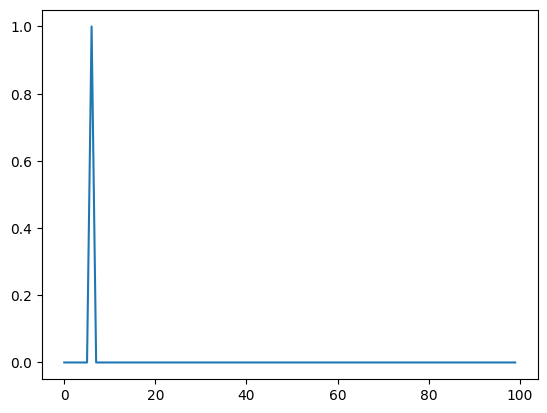

In [9]:
plt.plot(total_reward)
plt.show()

In [10]:
print(np.mean(total_reward))

0.01


Как видим, только в 2 эпизодах из 100 агену удалось добраться до цели.

Из среды OpenAI Gym мы можем получить элементы MDP (Markov Decision Process).

В env.env.P хранится двухуровневый словарь, в котором первый ключ является состояние, а второй - действием.
Клетки ассоциированыс индексами [0, 1, 2, ..., 15] слева направо и сверху вниз.

Индексы действией [0, 1, 2, 3] соответствуют движению на Запад, Юг, Восток и Север.
env.env.P[state][action] возвращает лист кортежей (probability, nextstate, reward). Например, состояние 0 - это начальное состояние и информация о веротностях перехода для s=0 и a=0 содержит:

In [11]:
env.env.P[0][0]

[(0.3333333333333333, 0, 0.0, False),
 (0.3333333333333333, 0, 0.0, False),
 (0.3333333333333333, 4, 0.0, False)]

Другой пример - состояние 5 сооветсвует проруби, и все действия в данном состоянии приводят к тому же состоянию с вероятностью 1 и наградой 0.

In [12]:
for i in range(4):
    print("P[5][%i] =" % i, env.env.P[5][i])

P[5][0] = [(1.0, 5, 0, True)]
P[5][1] = [(1.0, 5, 0, True)]
P[5][2] = [(1.0, 5, 0, True)]
P[5][3] = [(1.0, 5, 0, True)]


Вспомним, что из себя представляет алгоритм Value Iteration:
![img](value_iteration.png)

Будем считать задание решенным, если агент доходит до цели в среднем в 70% эпизодов. Напишем несклько вспомогательных функций. Запомним число состояний и действий в среде.

In [13]:
n_states = env.env.observation_space.n
n_actions = env.env.action_space.n
print("Number of states: {}".format(n_states))
print("Number of actions: {}".format(n_actions))

Number of states: 16
Number of actions: 4


Поскольку алгоритм Value Iteration возвращает нам оптимальную V-функцию, то нам необходимо извлекать из нее оптимальную политику (как указано в последней строке псевдокода алгоритма).

In [14]:
def extract_policy(v, gamma = 1.0):
    policy = np.zeros(n_states)
    for state in range(n_states):
        q = np.zeros(n_actions)
        for action in range(n_actions):
            for next_sr in env.env.P[state][action]:
                probability, next_state, reward, _ = next_sr
                q[action] += (probability*(reward + gamma*v[next_state]))
        policy[state] = np.argmax(q)
    return policy

Также напишем функцию для оценки нашей найденной политики.

In [15]:
def evaluate_policy(env, policy, gamma=1.0, n=100):
    total_reward = []
    for episode in range(n):
        episode_reward = 0
        observation = env.reset()
        step = 0
        for _ in range(100):
            env.render()
            action = int(policy[observation])
            observation, reward, done, _ = env.step(action)
            episode_reward += gamma**step*reward
            step += 1
            if done:
                break
        total_reward.append(episode_reward)
    return np.mean(total_reward)

Нам остается написать основную функцию, которая вернет оптимальную V-функцию.

In [16]:
def value_iteration(env, gamma=1.0, max_iterations = 100000):
    v = np.zeros(n_states)
    eps = 1e-20
    for i in range(max_iterations):
      prev_v = np.copy(v)

      for s in range(n_states):
        q_state_action = np.zeros(n_actions)

        for a in range(n_actions):
          q_state_action_state = 0

          for p, s_, r, _ in env.env.P[s][a]:
            q_state_action_state += p*(r + prev_v[s_])

          q_state_action[a] = q_state_action_state

        v[s] = max(q_state_action)
      if (np.sum(np.fabs(prev_v - v)) <= eps):
          print ('Value-iteration converged at iteration# %d.' %(i+1))
          break
    return v

In [17]:
def value_iteration(env, gamma = 1.0):
    """ Value-iteration algorithm """
    v = np.zeros(n_states)  # initialize value-function
    max_iterations = 100000
    eps = 1e-20
    for i in range(max_iterations):
        prev_v = np.copy(v)
        for s in range(n_states):
            q_sa = [sum([p*(r + prev_v[s_]) for p, s_, r, _ in env.env.P[s][a]]) for a in range(n_actions)]
            v[s] = max(q_sa)
        if (np.sum(np.fabs(prev_v - v)) <= eps):
            print ('Value-iteration converged at iteration# %d.' %(i+1))
            break
    return v

Теперь мы можем найти оптимальную V-функцию, извлечь из нее оптимальную политику и оцениь ее.

In [18]:
optimal_v = value_iteration(env)
optimal_policy = extract_policy(optimal_v)
optimal_policy_score = evaluate_policy(env, optimal_policy, n=100)

Value-iteration converged at iteration# 1373.


In [19]:
print(optimal_v.reshape(4,4))

[[0.82352941 0.82352941 0.82352941 0.82352941]
 [0.82352941 0.         0.52941176 0.        ]
 [0.82352941 0.82352941 0.76470588 0.        ]
 [0.         0.88235294 0.94117647 0.        ]]


In [20]:
print(optimal_policy.reshape(4,4))

[[0. 3. 3. 3.]
 [0. 0. 0. 0.]
 [3. 1. 0. 0.]
 [0. 2. 1. 0.]]


In [21]:
print(optimal_policy_score)

0.77


По сравнению со "случайным" агентом, который доходил до цели в 2 случаях из 100, наша новая политика позволяет добирться до цели в ~70% эпизодов.

## Policy Iteration

Вспомним, что из себя представляет алгоритм Policy Iteration
![](img/policy_iteration.png)



Напишем 2 функции, которые используются в основном цикле алгоритма Policy Iteration согласно псевдокоду.

In [22]:
def compute_policy_v(env, policy, gamma=1.0, eps=1e-10):
    v = np.zeros(n_states)
    # Your code goes here
    while True:
      prev_v = np.copy(v)

      for s in range(n_states):
          policy_a = policy[s]
          v[s] = 0
          for p, s_, r, _ in env.env.P[s][policy_a]:
            v[s] += p * (r + gamma * prev_v[s_])

      if (np.sum((np.fabs(prev_v - v))) <= eps):
          # value converged
          break
    return v

In [23]:
def extract_policy(v, gamma=1.0):
    policy = np.zeros(n_states)
    # Your code goes here
    for s in range(n_states):
        q_sa = np.zeros(n_actions)
        for a in range(n_actions):
            q_sa[a] = sum([p * (r + gamma * v[s_]) for p, s_, r, _ in  env.env.P[s][a]])
        policy[s] = np.argmax(q_sa)
    return policy

Теперь запишем основной цикл алгоритма, который вернет нам оптимальную политику.

In [24]:
def policy_iteration(env, gamma=1.0, max_iterations = 200000):
    policy = np.random.choice(n_actions, size=(n_states))  # initialize a random policy
    for i in range(max_iterations):
        old_policy_v = compute_policy_v(env, policy, gamma)
        new_policy = extract_policy(old_policy_v, gamma)
        if (np.all(policy == new_policy)):
            print ('Policy-Iteration converged at step %d.' %(i+1))
            break
        policy = new_policy
    return policy

Теперь мы также можем найти оптимальную V-функцию, извлечь из нее оптимальную политику и оцениь ее.

In [25]:
optimal_policy = policy_iteration(env)
optimal_policy_score = evaluate_policy(env, optimal_policy)

Policy-Iteration converged at step 7.


In [26]:
print(optimal_policy.reshape(4,4))

[[0. 3. 3. 3.]
 [0. 0. 0. 0.]
 [3. 1. 0. 0.]
 [0. 2. 1. 0.]]


In [27]:
print(optimal_policy_score)

0.77


![](https://drive.google.com/uc?export=view&id=1OlzVdezDCeeNmcEl1VQg1DmlqkA6CCBZ)